# Experiment 1
Compare the effect of autoencoder vs deepautoencoder vs direct solver

## Helper functions

In [2]:

from features import *
from metrics import *
import os
import torch as t
import torch.nn as nn
# from features import *


os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

def noisy_toy(prob, noise_level, hidden, features, size, dtype = t.float32):    
    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    true_emb = t.randn(features, hidden).to(device)
    true_emb /= t.norm(true_emb, dim = 1).reshape(-1, 1)
    true_emb = true_emb.to(device)
    ground_truth = (t.rand((size, features)) < prob).to(dtype).to(device)
    acti = ground_truth @ true_emb
    noise = t.randn(acti.shape).to(acti.device) * noise_level
    acti = acti + noise * noise_level
    info = {"emb": true_emb, "feat": ground_truth}
    return acti, info


In [6]:
r2list = [[] for i in range(3)]
sparsity_list = [[] for i in range(3)]
mmcs_list = [[] for i in range(3)]
for dims in [20, 40, 80, 160]:
    num_feats = 5
    features = 4 * dims
    acti, metainfo = noisy_toy(num_feats / features, 0.3 / (dims ** 0.5), dims, features, 4000)
    true_feat = metainfo["feat"]
    true_emb = metainfo["emb"]
    for tp in range(3):
        if tp == 0: # autoencoder
            feat, emb, info = AutoEncoder_solver(acti.clone(), guess_factor = 8, lr = 3e-3, epochs = 3000, batch_size = 512, init_lamb = 0.35, lamb_left = 0.4, lamb_right = 0.6, 
                                                 adaptive = False, use_deep = False)
        elif tp == 1: # deep
            feat, emb, info = AutoEncoder_solver(acti.clone(), guess_factor = 8, lr = 3e-3, epochs = 3000, batch_size = 512, init_lamb = 0.35, lamb_left = 0.4, lamb_right = 0.6, 
                                                 adaptive = False, use_deep = True) 
        else:
            feat, emb, info = GD_solver(acti.clone(), guess_factor = 8, lr = 3e-3, steps = 10000, init_lamb = 0.35, lamb_left = 0.4, lamb_right = 0.6, adaptive = False)

        corr = average_r2(true_feat, feat)
        sparsity = metric_total_acti(feat)
        mmcs_val = mmcs(true_emb, emb)
        r2list[tp].append(corr)
        sparsity_list[tp].append(sparsity)
        mmcs_list[tp].append(mmcs_val)
        print(f"Dimension:{dims}, type:{tp}")
        print(f"Average correlation:{corr}")
        print(f"Sparsity:{sparsity}, actual:{metric_total_acti(true_feat.cpu())}")
        print(f"MMCS:{mmcs_val}")

Executing with num_features: 160 and feature_dim: 20 and reg_param: 0.35


Epoch loss: 0.0151072916, Avg coeffs: 55.038: 100%|██████████| 3000/3000 [00:58<00:00, 50.88it/s]


Best coeffs:0
torch.Size([160, 20])
Dimension:20, type:0
Average correlation:0.14226707278496137
Sparsity:12.7781678886362, actual:5.015094757080078
MMCS:0.6991803164373078
Executing with num_features: 160 and feature_dim: 20 and reg_param: 0.35


Epoch loss: 0.0138892059, Avg coeffs: 38.213: 100%|██████████| 3000/3000 [01:14<00:00, 40.23it/s]


Best coeffs:0
torch.Size([160, 20])
Dimension:20, type:1
Average correlation:0.16054384276045836
Sparsity:8.671326330171727, actual:5.015094757080078
MMCS:0.7537565755544928
torch.Size([4000, 20])


100%|██████████| 10000/10000 [00:11<00:00, 875.29it/s, accuracy=0, loss=5.41e+3]


Dimension:20, type:2
Average correlation:0.4075937086004494
Sparsity:3.8696460723876953, actual:5.015094757080078
MMCS:0.9823652505874634
Executing with num_features: 320 and feature_dim: 40 and reg_param: 0.35


Epoch loss: 0.0099623331, Avg coeffs: 101.994:  37%|███▋      | 1114/3000 [00:21<00:38, 49.60it/s]

Helper functions for plotting

In [ ]:
name = ["Autoencoder", "Deep", "GD"]
def plot_figure(values, title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Dimension")
    plt.ylabel("Value")
    for i in range(3):
        plt.plot([20, 40, 80, 160], values[i], label = name[i])
    plt.legend()
    plt.show()
plot_figure(r2list, "Average correlation")
plot_figure(sparsity_list, "Sparsity")
plot_figure(mmcs_list, "MMCS")

In [5]:
feat1, emb1, info1 = GD_solver(acti.clone(), guess_factor = 8, lr = 3e-3, steps = 10000, init_lamb = 0.35, lamb_left = 0.4, lamb_right = 0.6, adaptive = False)
print(f"Average correlation:{average_r2(true_feat, feat1, True)}")
print(f"Sparsity:{metric_total_acti(feat1)}, actual:{metric_total_acti(true_feat.cpu())}")
print(f"MMCS:{mmcs(true_emb, emb1)}")


torch.Size([5000, 10])


100%|██████████| 10000/10000 [00:14<00:00, 676.66it/s, accuracy=0, loss=3.91e+3]


Average correlation:0.38911544789198793
Sparsity:2.607215404510498, actual:3.125051975250244
MMCS:0.9552534222602844


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0') tensor([0.0000, 0.4570, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0') tensor([ 2.9012e-05,  1.4047e-04, -4.1133e-05,  ...,  3.9692e-05,
         7.9736e-05,  4.2892e-04])
-45.362464613105324
-131.35789242655392
torch.Size([66, 10])


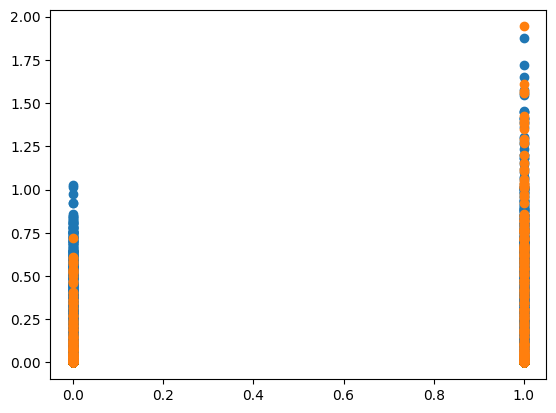

In [ ]:
def plot_feat(feat1):
    for i in range(1):
        maxr2 = -100
        id = 0
        for j in range(feat1.shape[1]):
            # print(r2(ground_truth[:, i].cpu().numpy(), feat[:, j].cpu().numpy()))
            rval = r2(true_feat[:, i].cpu().numpy(), feat1[:, j].cpu().numpy())
            if rval > maxr2:
                maxr2 = rval
                id = j
    print(true_feat[:, 0], feat1[:, id])
    import matplotlib.pyplot as plt
    plt.plot(true_feat[:, 0].cpu().numpy(), feat1[:, id].cpu().numpy(), 'o')

def average_r2(ground_truth, acti):
    baseline_r2 = []
    for i in range(ground_truth.shape[1]):
        maxr2 = -100
        for j in range(acti.shape[1]):
            # print(r2(ground_truth[:, i].cpu().numpy(), feat[:, j].cpu().numpy()))
            rval = r2(ground_truth[:, i].cpu().numpy(), acti[:, j].cpu().numpy())
            if rval > maxr2:
                maxr2 = rval
        cursum = 0
        for j in range(acti.shape[1]):
            rval = r2(ground_truth[:, i].cpu().numpy(), acti[:, j].cpu().numpy())
            if rval > 0:#maxr2 / 2:
                cursum += acti[:, j].cpu().numpy()
        baseline_r2.append(r2(ground_truth[:, i].cpu().numpy(), cursum))
    return np.mean(baseline_r2)
plot_feat(feat)
plot_feat(feat1)
# newf, newe = condense_features(feat1, emb1, 0.65)
# print(average_r2(true_feat, newf))
print(average_r2(true_feat, feat1))
print(average_r2(true_feat, feat))
print(newe.shape)

In [48]:
print(mmcs(true_emb, emb))
print(mmcs(true_emb, emb1))
print(metric_total_acti(feat))
print(metric_total_acti(feat1))
# print(average_r2(ground_truth, feat))
# get max feat1, 0
chkmax0 = t.maximum(feat1, t.zeros_like(feat1))
print(average_r2(ground_truth, chkmax0))


0.8616426
0.8616426
0.9683758
0.9683758
4.452575
2.6176965


TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
